In [171]:
# Imports
library(Seurat)
library(SingleCellExperiment)
library(SingleR)
library(celldex)    
library(ggplot2)
library(clustree)
library(stringr) 
library(gridExtra)
library(dplyr)

# Change setting for visualizing plots within VSCODE
options(repr.plot.width=18, repr.plot.height=12)

# Read Winkels et al. (2020)
macrophage_data <- readRDS("../../../data/R Objects/Annotated Subtype Objects/Winkels_macrophages_annotated.rds")

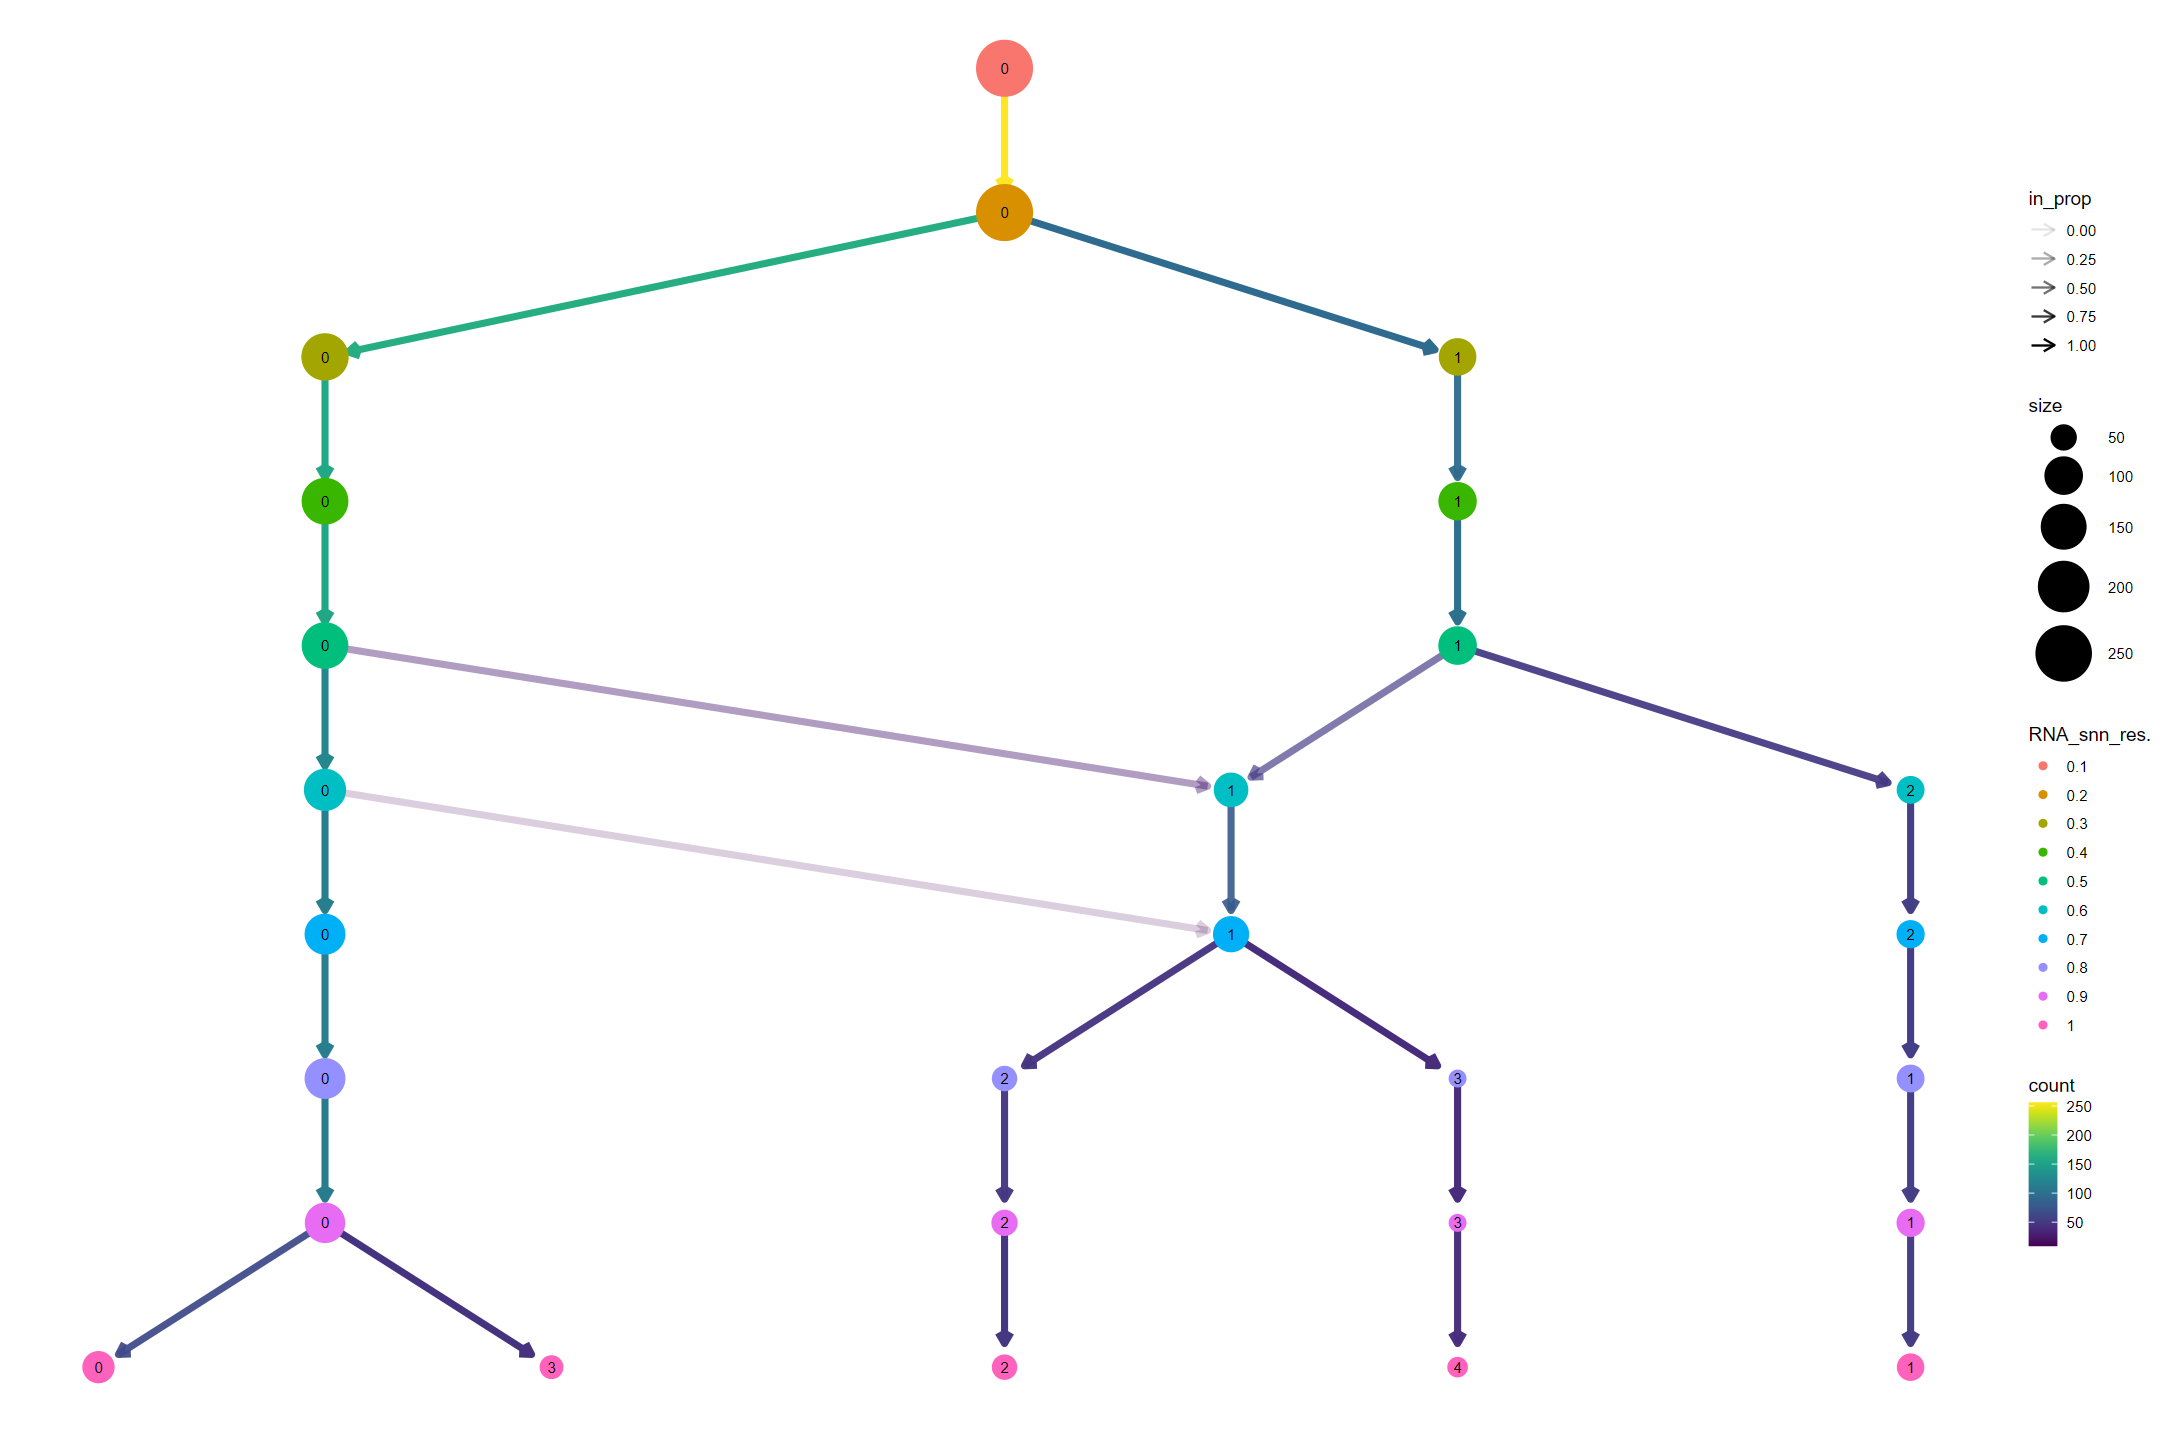

In [19]:
# This cell is meant to analyze the different resolutions and see which one is the best
clustree(macrophage_data, prefix= "RNA_snn_res.", layout = "sugiyama")

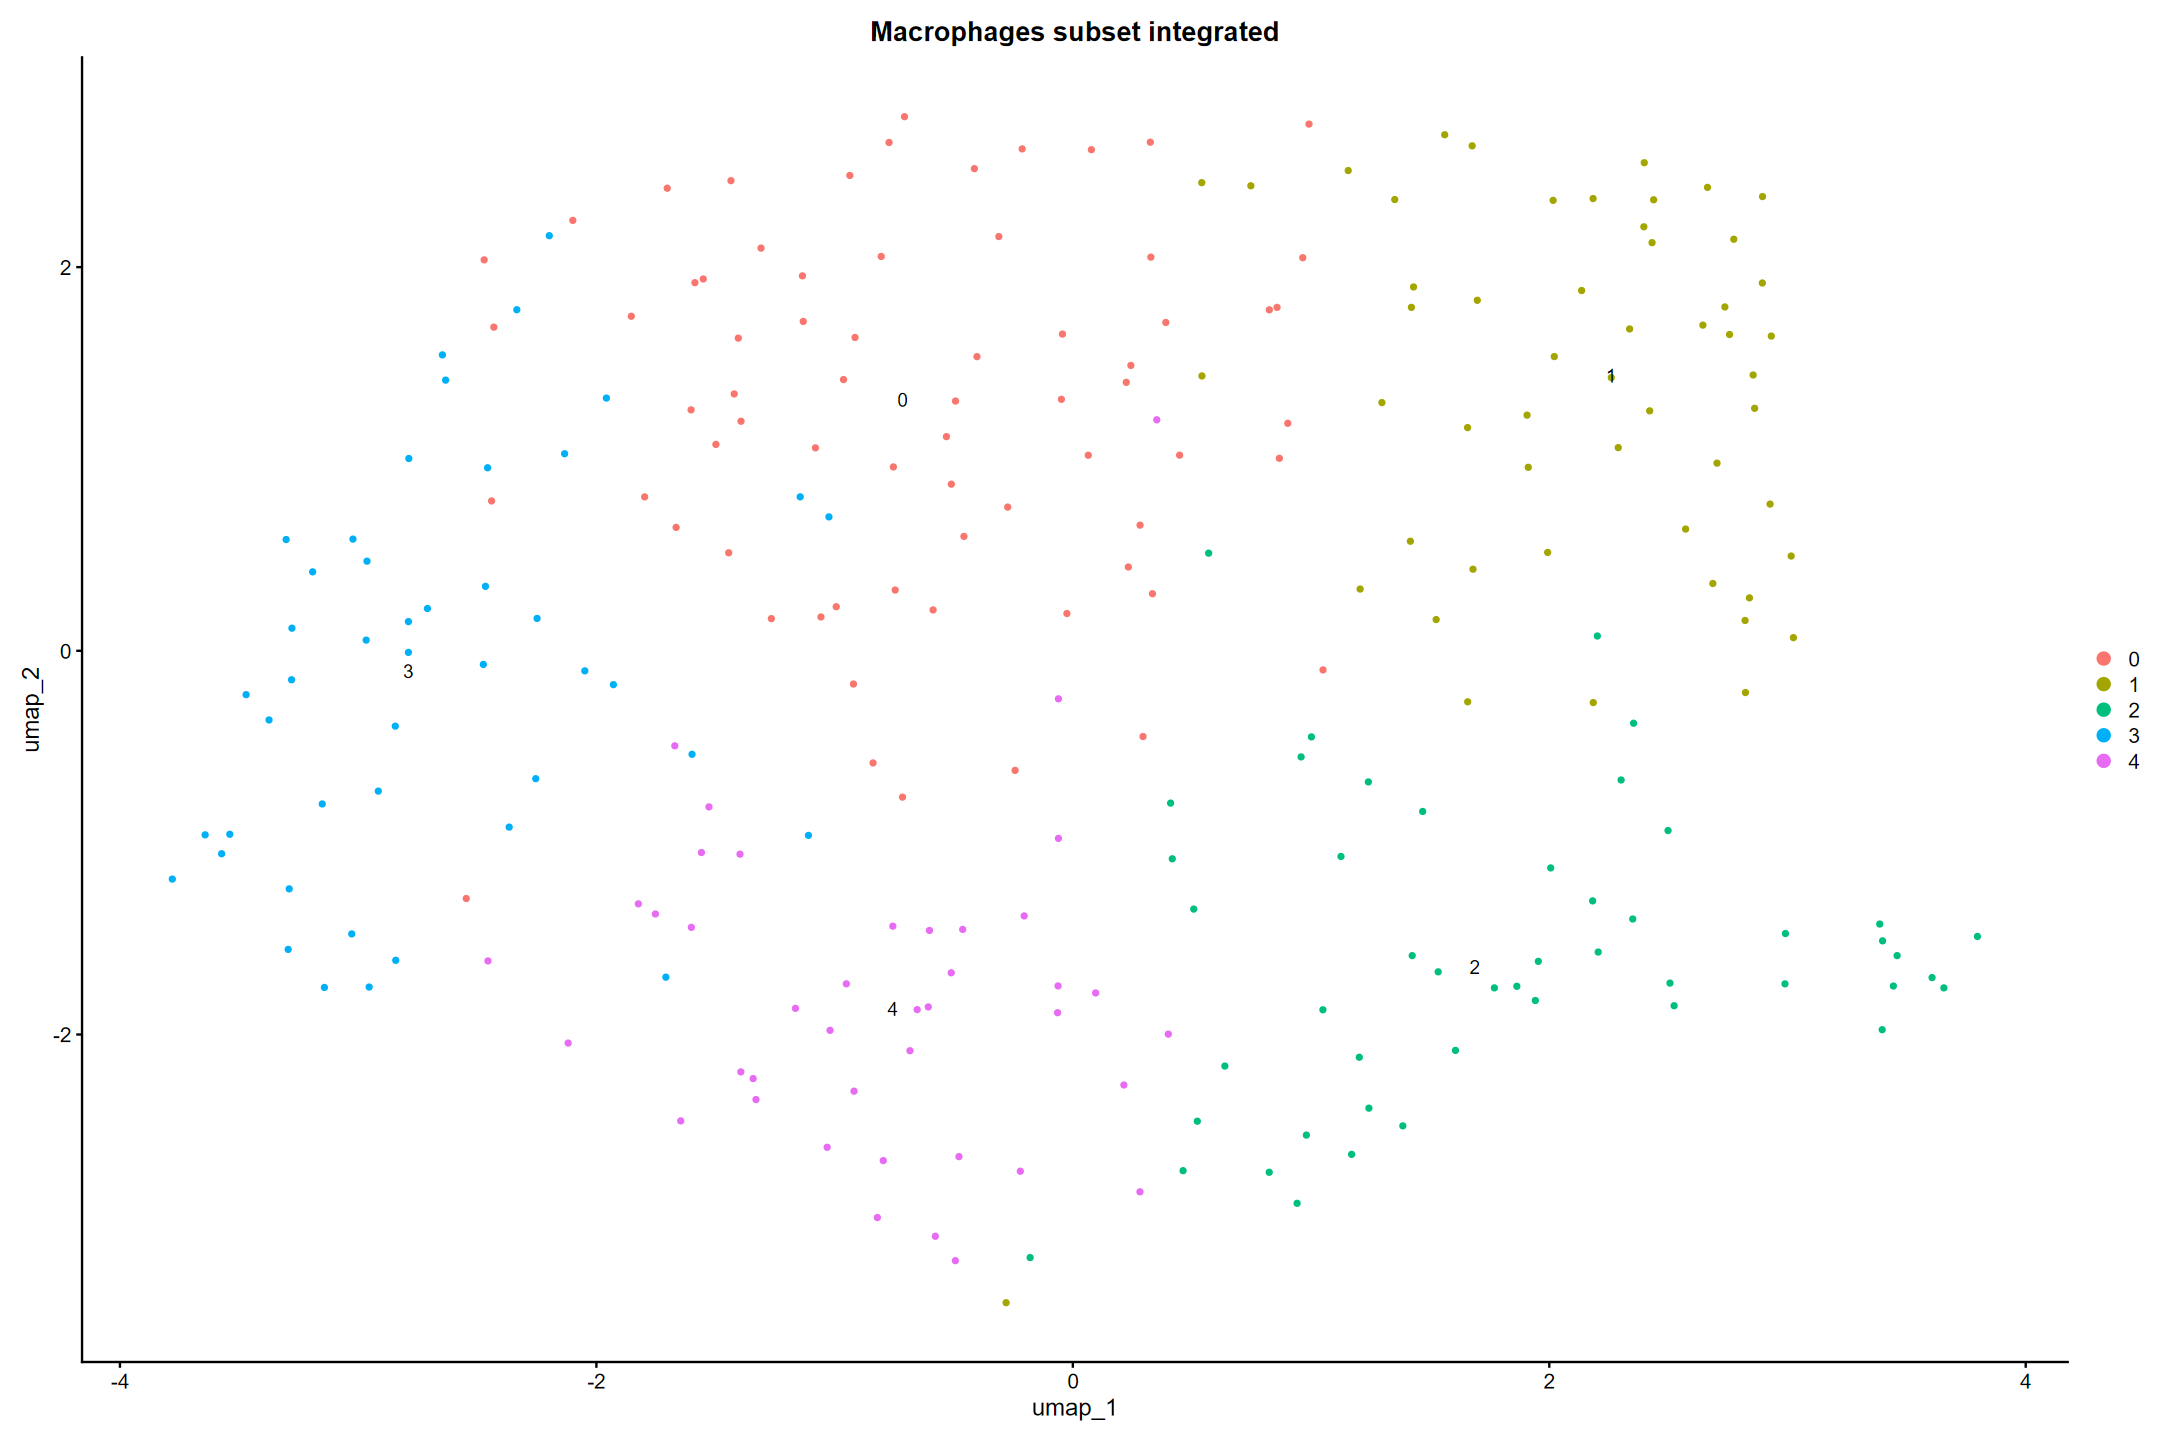

In [176]:
# Assign the slot "Seurat Cluster" to the desired resolution
macrophage_data$seurat_clusters <- macrophage_data$`RNA_snn_res.1`
macrophage_data <- SetIdent(macrophage_data, value = "seurat_clusters")

#Idents(macrophage_data) <- "seurat_clusters"

# Plot
DimPlot(macrophage_data, reduction = "umap", group.by = "RNA_snn_res.1", label = TRUE) + 
    ggtitle("Macrophages subset integrated")

In [177]:
# Some marker genes according to Winther & Willemsen
features_inflammatory <- c("S100a8", "S100a9", "Il1b", "Casp1", "Casp4", "Nlrp3", "Tnf", "Egr1", "Zpf36", "Ier3", "Cepbp", "Cxcl2", "Ccl2-5")
features_resident <- c("Lyve1", "Cx3cr1", "Folr2", "C1qa", "C1qb", "C1qc", "Cd74", "Hla-dra", "Hla-drb1", "Pf4", "Sepp1", "Vsig4", "F13a1")
features_trem2 <- c("Trem2", "Cd9", "Fabp5", "Apoe", "Apoc1", "Spp1", "Lgals3", "Ctsb")
features_ifnic <- c("Isg15", "Irf7", "Ifit3", "Ifit1")
features_proliferating <- c("Stmn1", "Top2a", "Mki67", "Tuba1b", "Tubb5")

# Add a module score to the Seurat object
macrophage_data <- AddModuleScore(macrophage_data, features = list(features_inflammatory), name = "FeatureGeneScore_inflammatory")
macrophage_data <- AddModuleScore(macrophage_data, features = list(features_resident), name = "FeatureGeneScore_resident_like")
macrophage_data <- AddModuleScore(macrophage_data, features = list(features_trem2), name = "FeatureGeneScore_trem2")
macrophage_data <- AddModuleScore(macrophage_data, features = list(features_ifnic), name = "FeatureGeneScore_ifnic")
macrophage_data <- AddModuleScore(macrophage_data, features = list(features_proliferating), name = "FeatureGeneScore_proliferating")

# Vln plots
inflammatory_vln <- VlnPlot(macrophage_data, features = "FeatureGeneScore_inflammatory1", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for inflammatory macrophage markers")
residents_vln <- VlnPlot(macrophage_data, features = "FeatureGeneScore_resident_like1", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for resident-like macrophage markers")
trem2_vln <- VlnPlot(macrophage_data, features = "FeatureGeneScore_trem21", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for trem2 foamy macrophage markers")
ifn_vln <- VlnPlot(macrophage_data, features = "FeatureGeneScore_ifnic1", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for trem2 foamy macrophage markers")
proliferating_vln <- VlnPlot(macrophage_data, features = "FeatureGeneScore_proliferating1", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for trem2 foamy macrophage markers")

# Visualizing DotPlots to view marker genes
inflammatory_dot <- DotPlot(macrophage_data, features = features_inflammatory) + 
  ggtitle("Inflammatory Macrophages") + RotatedAxis()

resident_dot <- DotPlot(macrophage_data, features = features_resident) + 
  ggtitle("Resident-Like Macrophages")

TREM2_dot <- DotPlot(macrophage_data, features = features_trem2) + 
  ggtitle("TREM2 'Foamy' Macrophages")

IFNIC_dot <- DotPlot(macrophage_data, features = features_ifnic) + 
  ggtitle("IFNIC Macrophages")

proliferating_dot <- DotPlot(macrophage_data, features = features_proliferating) + 
  ggtitle("Proliferating Macrophages")


Warning message:
"The following features are not present in the object: Zpf36, Cepbp, Ccl2-5, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: Hla-dra, Hla-drb1, not searching for symbol synonyms"
Warning message:
"The following requested variables were not found: Zpf36, Cepbp, Ccl2-5"
Warning message:
"The following requested variables were not found: Hla-dra, Hla-drb1"


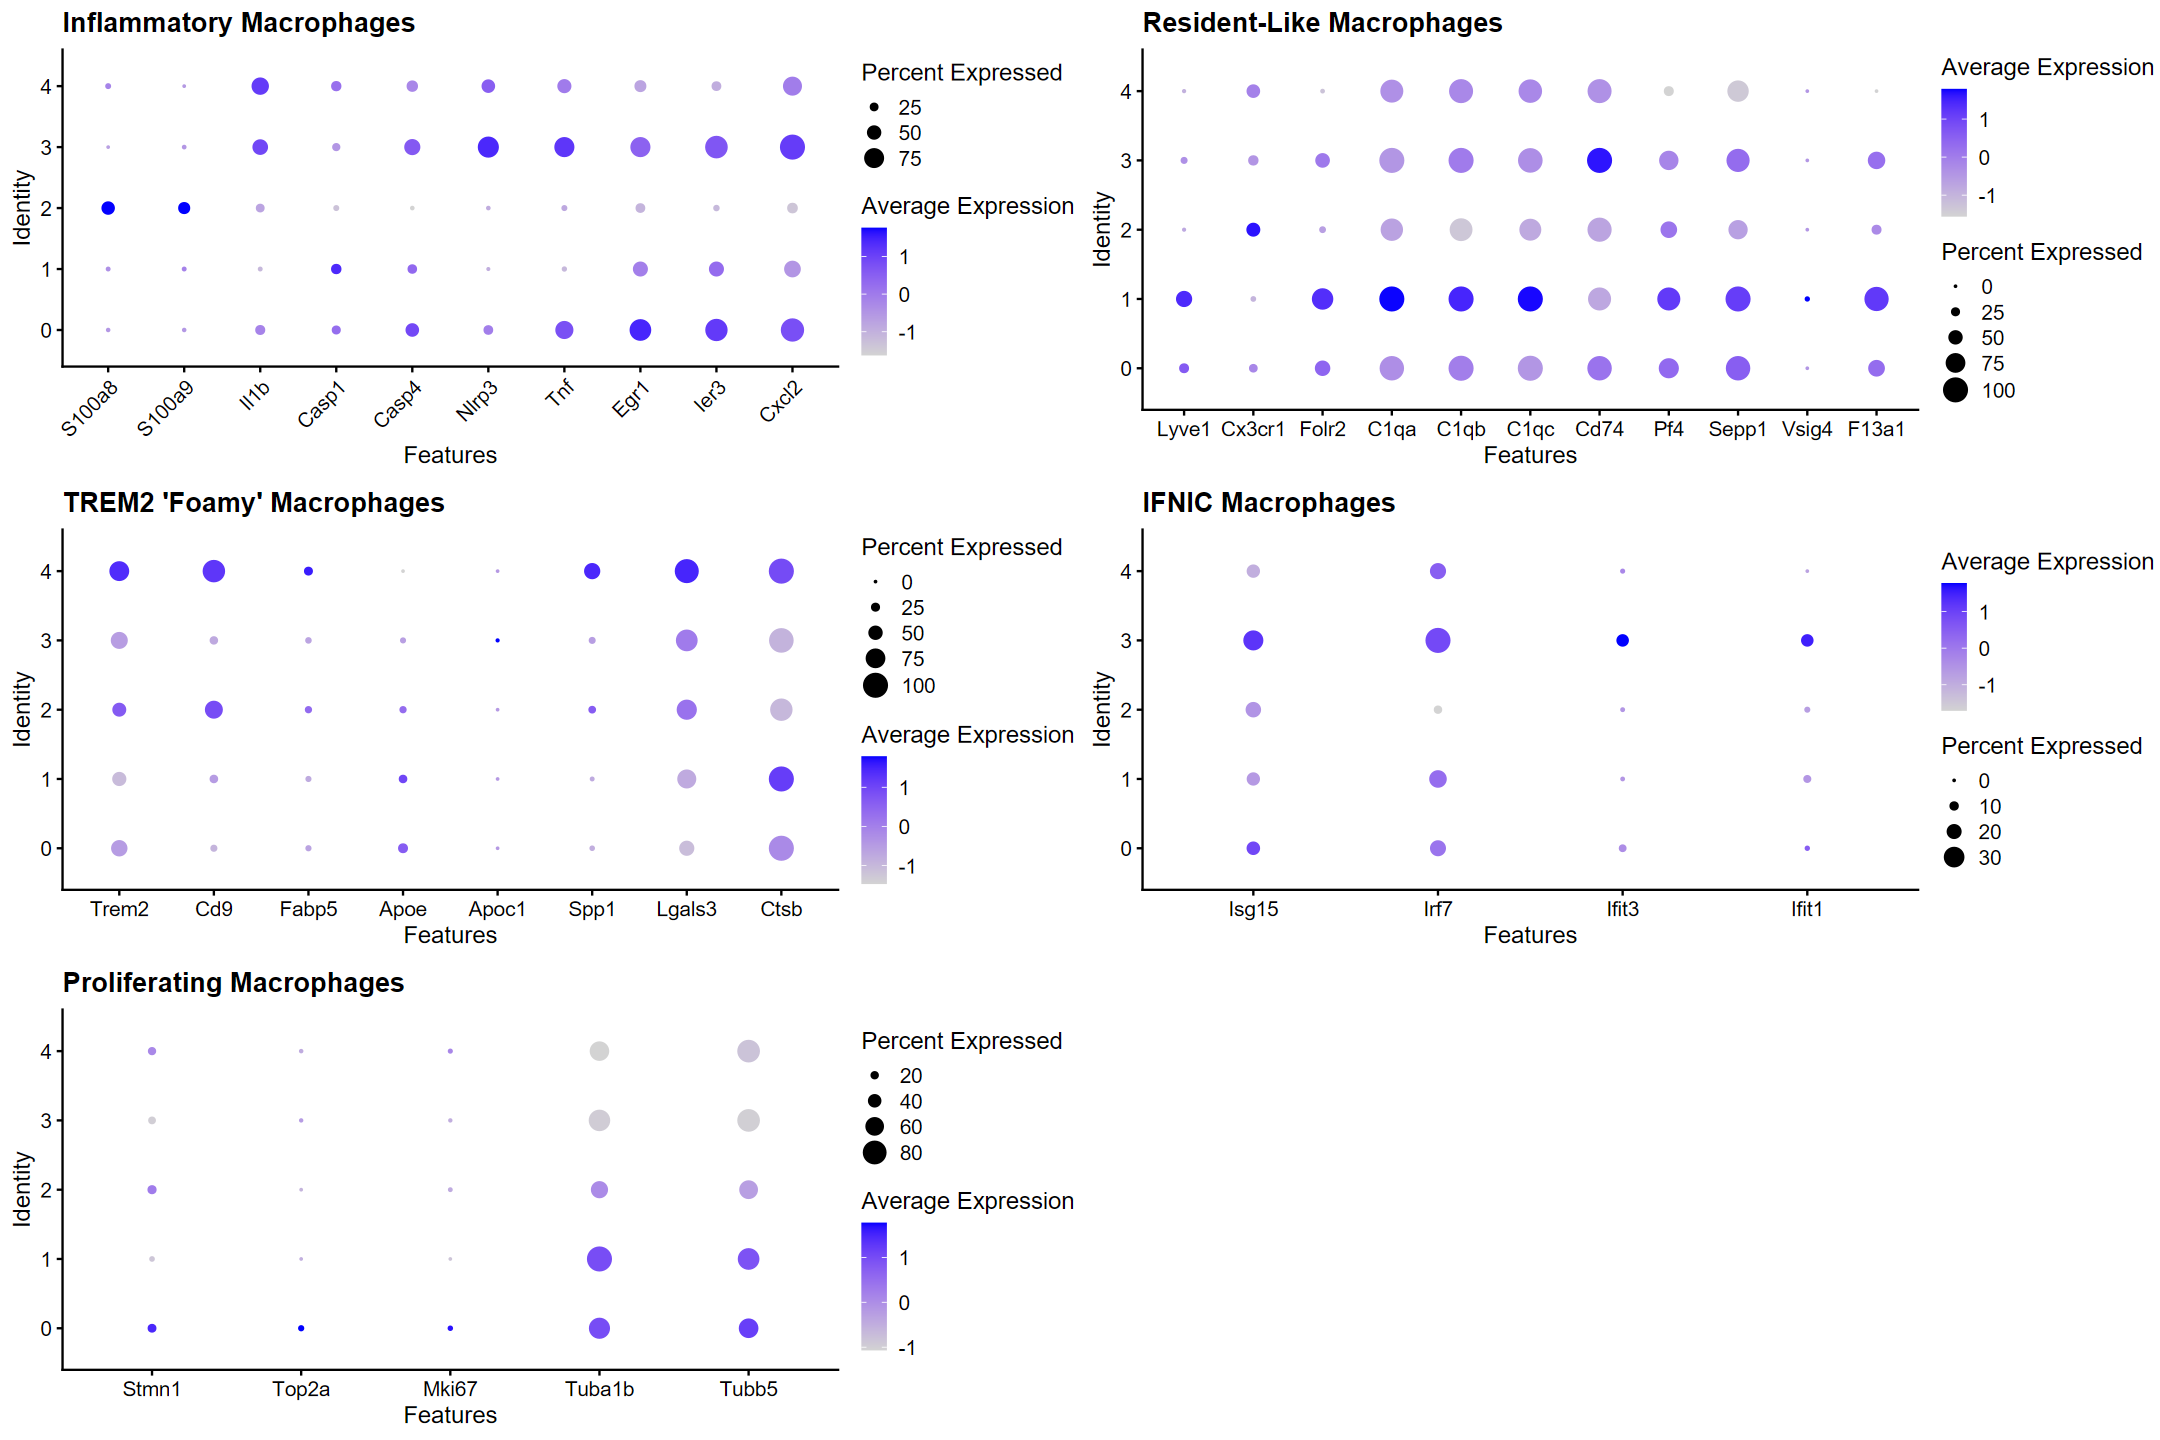

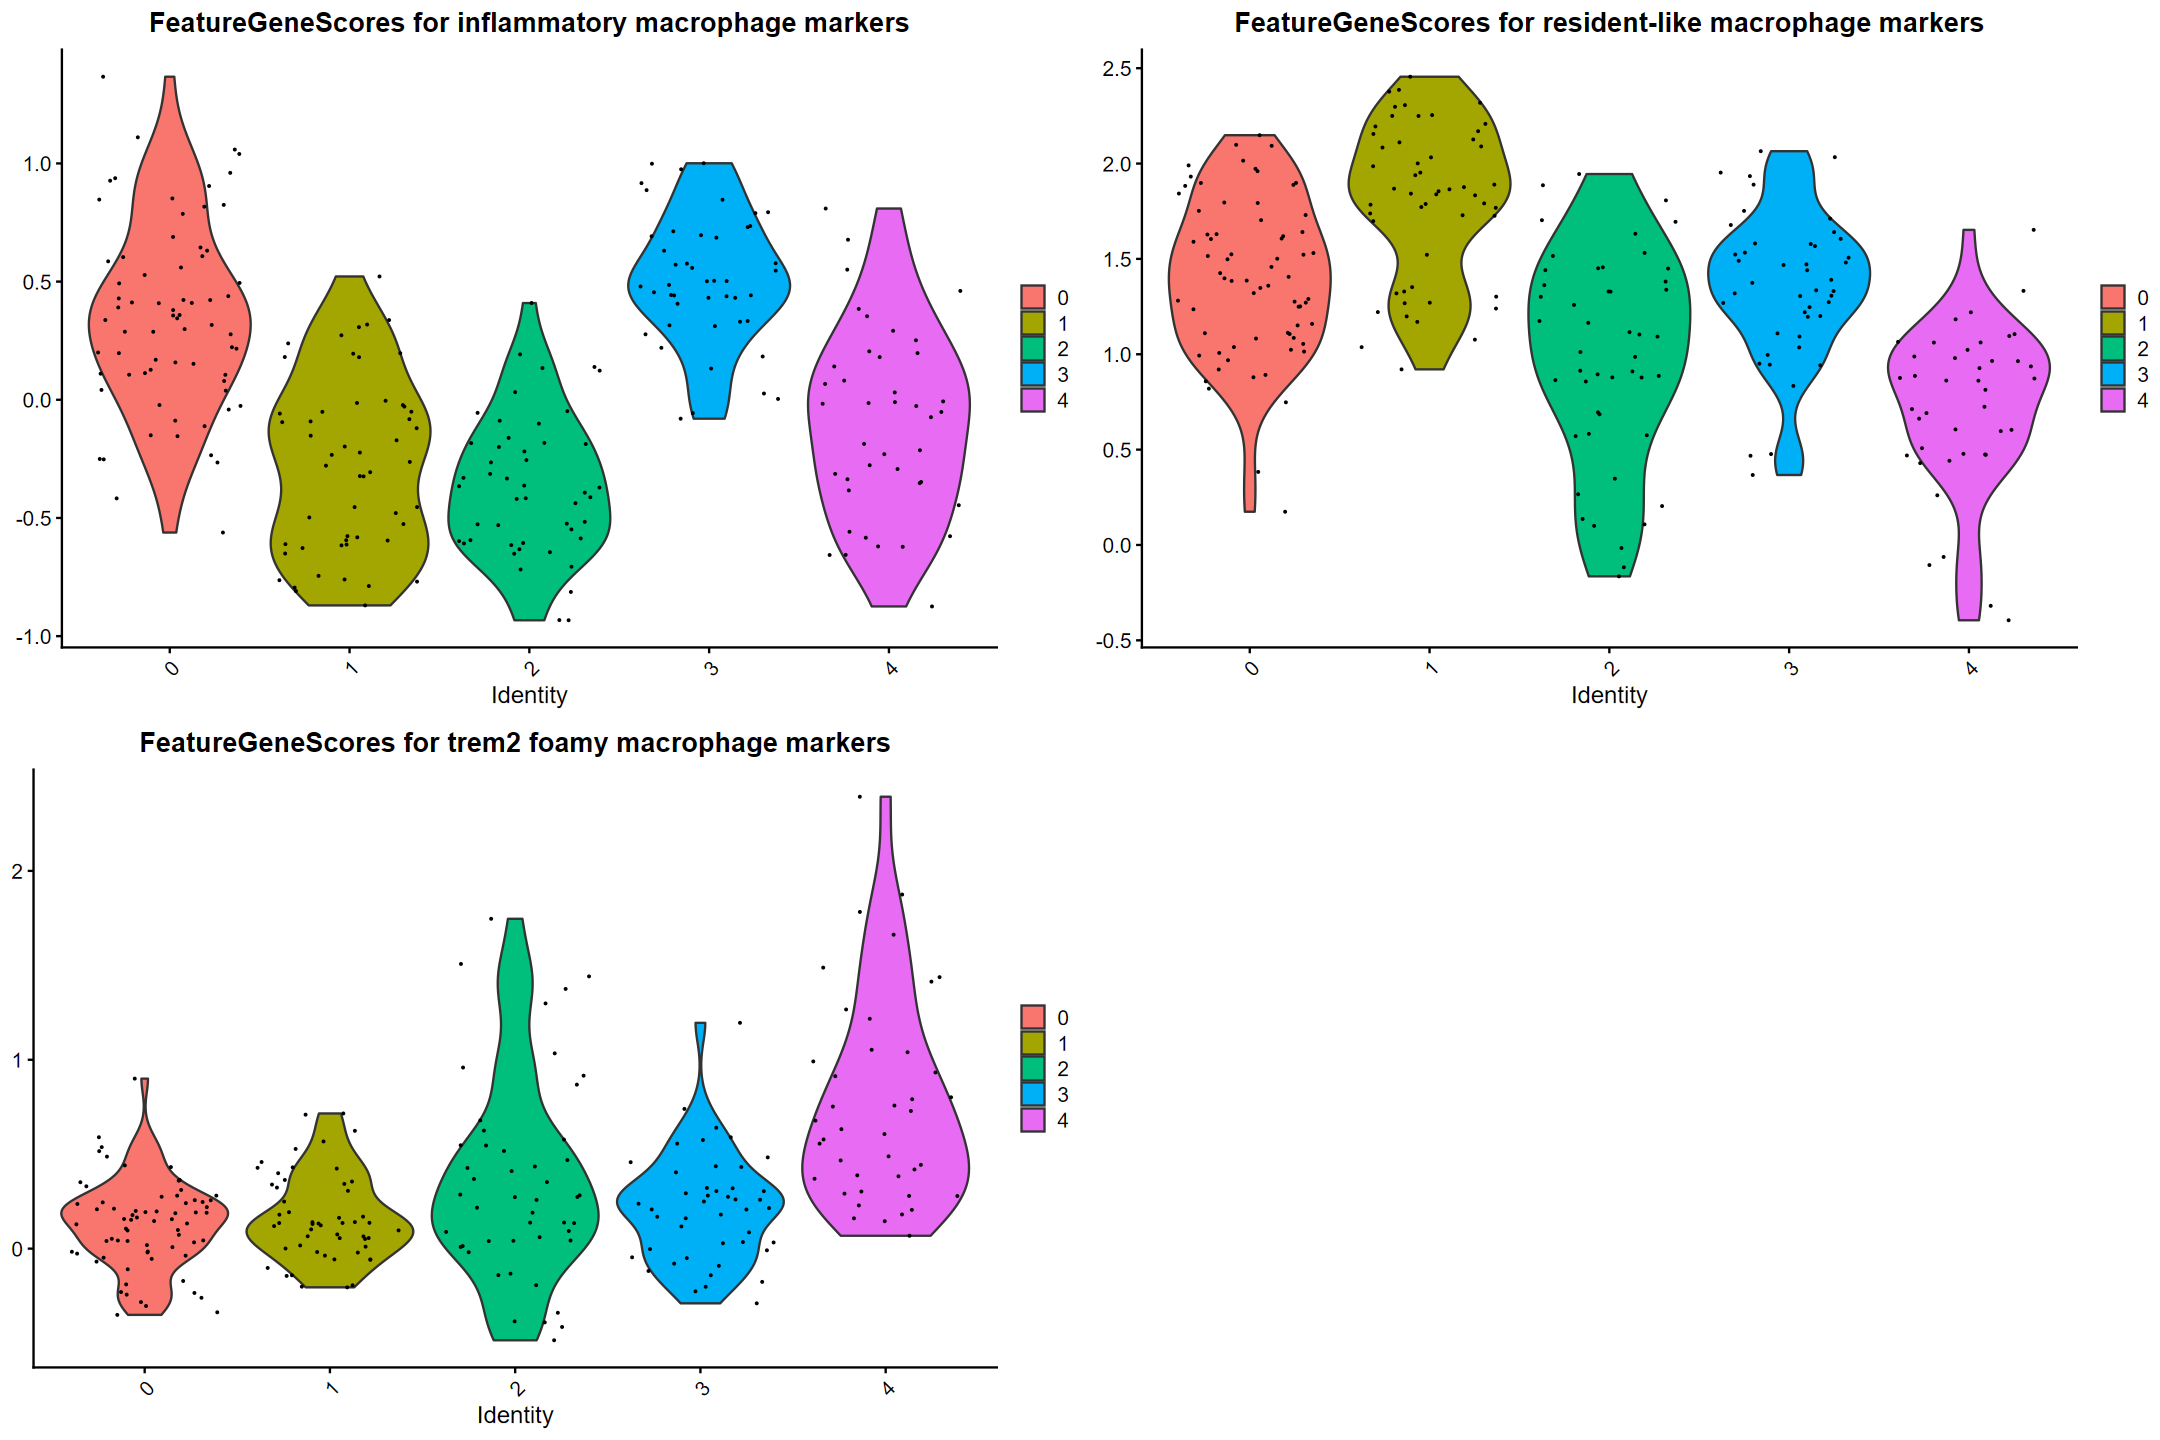

In [178]:
# Plot
grid.arrange(inflammatory_dot, resident_dot, TREM2_dot, IFNIC_dot, proliferating_dot, ncol = 2)
grid.arrange(inflammatory_vln, residents_vln, trem2_vln, ncol=2)


Calculating cluster 0



Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Warning message in DoHeatmap(macrophage_data, features = top10$gene, size = 1, angle = 0, :
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: Lhfpl2, Gm10709, Gm10263, S100a9, S100a8, Rab29, Dnajc30, Apip, Selenbp1"
Warning message in viridisLite::viridis(n, alpha, begin, end, direction, option):
"Option 'blue' does not exist. Defaulting to 'viridis'."
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


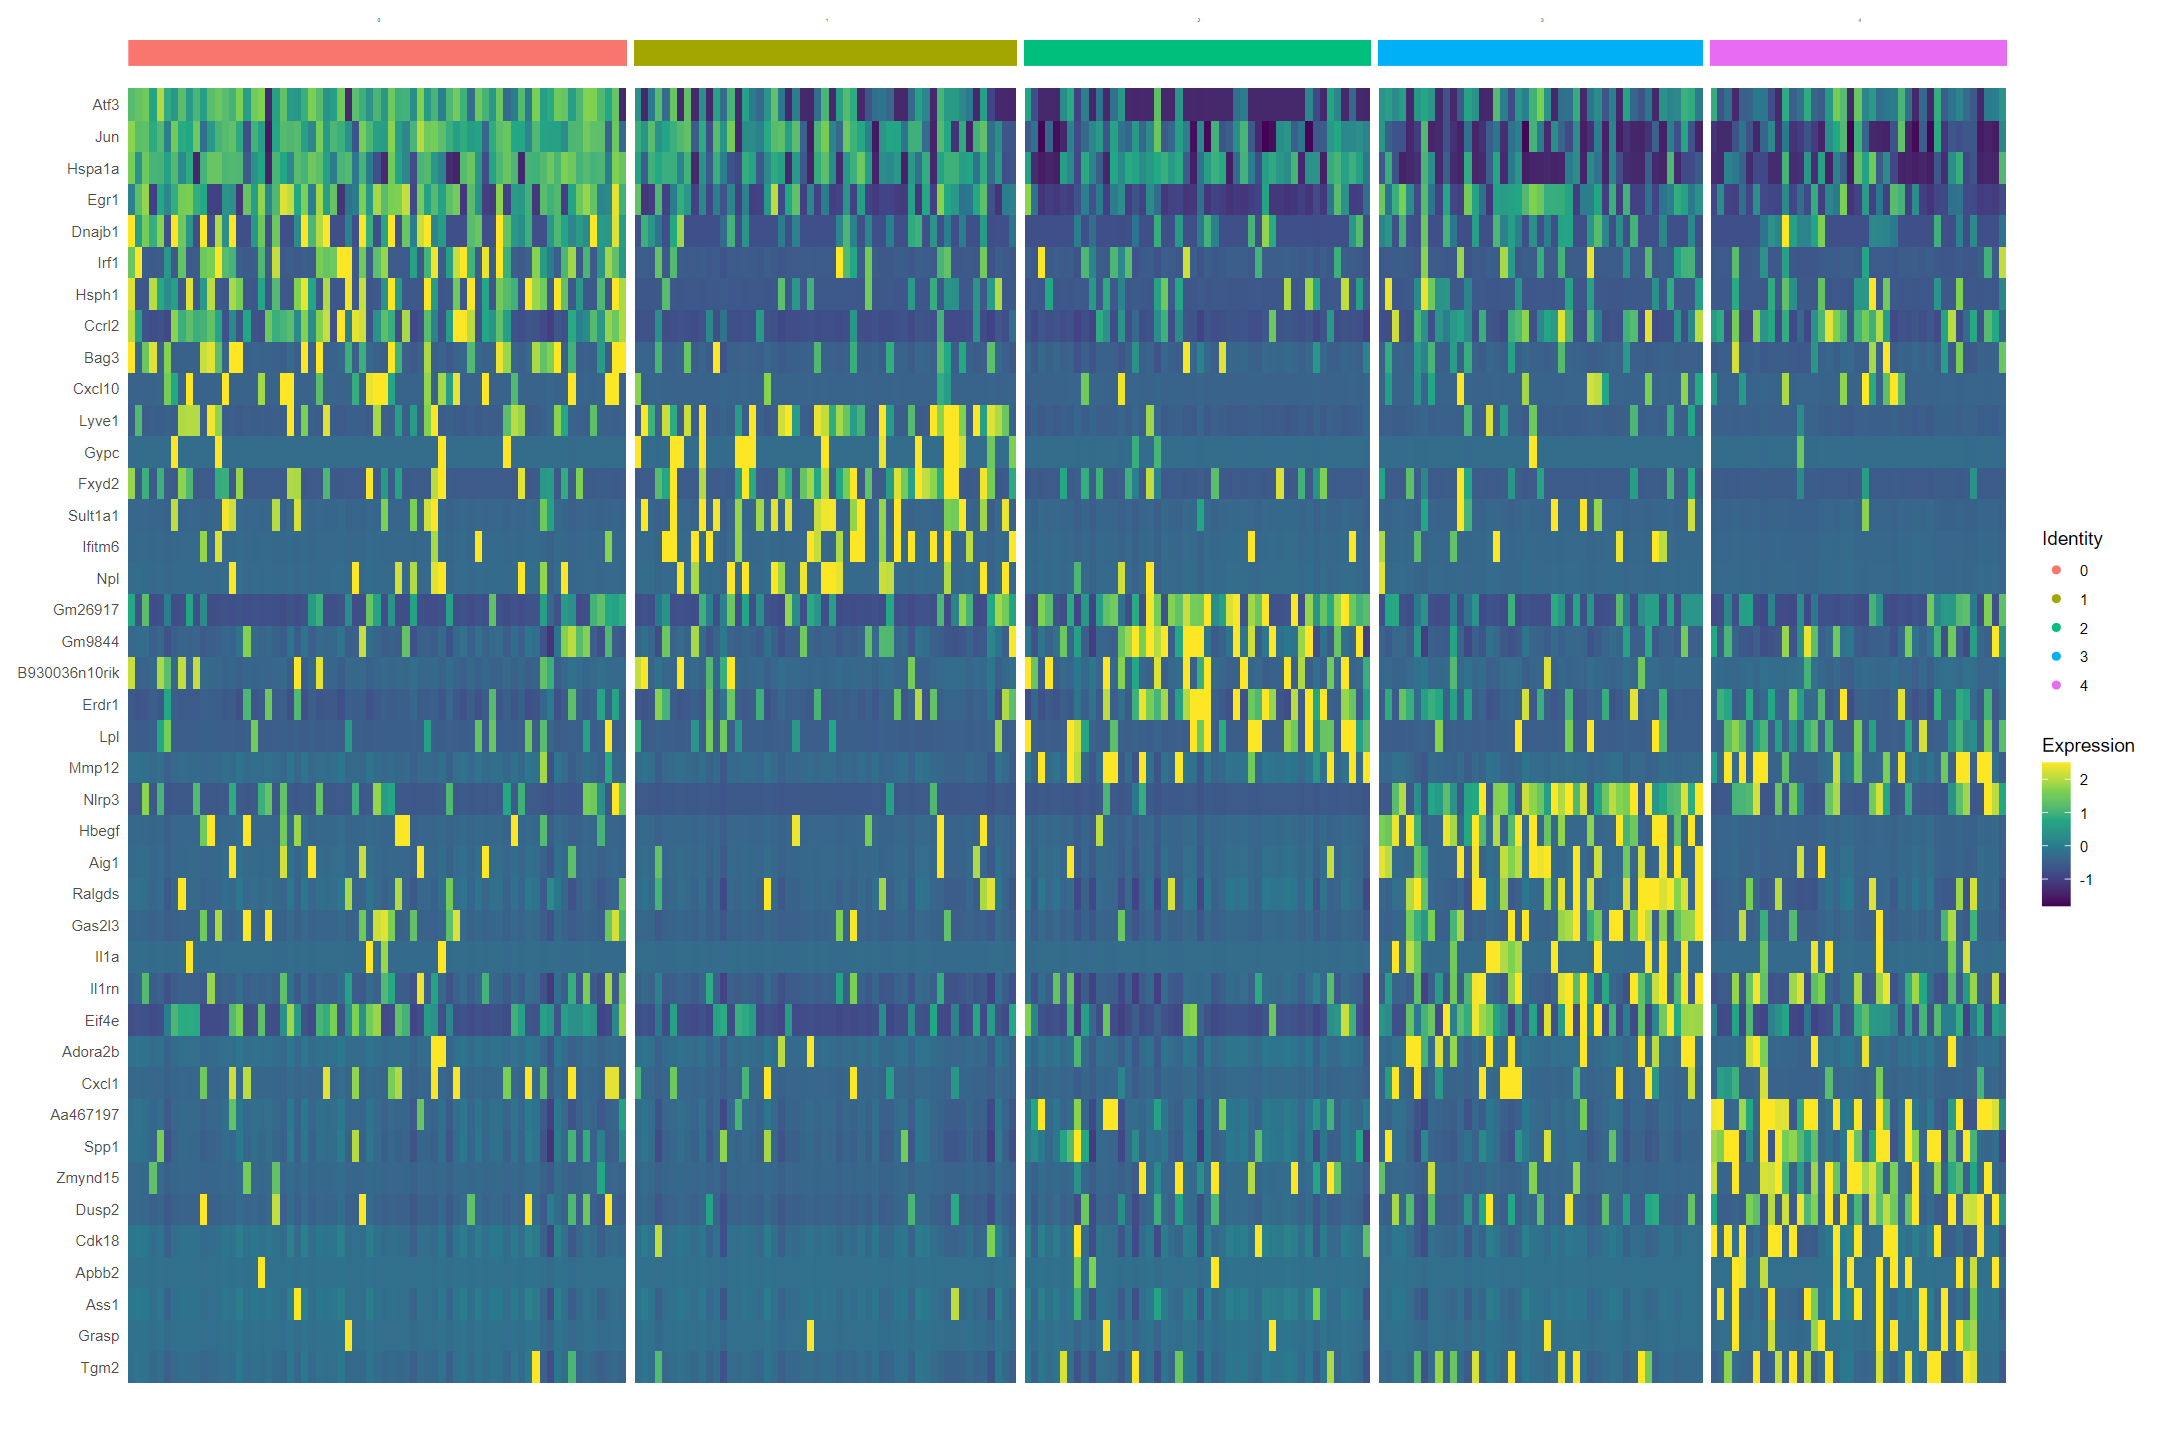

In [ ]:
# Find markers for each cluster
markers <- FindAllMarkers(macrophage_data, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
markers %>%
  group_by(cluster) %>%
  dplyr::filter(avg_log2FC > .75) %>%
  slice_head(n = 10) %>%
  ungroup() -> top10

# Heatmap
top10 <- markers %>% group_by(cluster) %>% top_n(10, avg_log2FC)
DoHeatmap(macrophage_data, features = top10$gene, size=1, angle=0, raster=FALSE) &
  scale_fill_viridis_c(option="blue",na.value = "white")

In [142]:
# Markers
markers %>% group_by(cluster) %>% filter(p_val_adj < 0.05) %>% slice_max(order_by = avg_log2FC, n = 5) %>% arrange(cluster, desc(pct.1)) 

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
2.539203e-16,1.859901,0.986,0.695,7.109261e-12,0,Jun
2.794507e-18,1.940028,0.957,0.668,7.824062e-14,0,Atf3
7.619966e-10,2.794859,0.710,0.396,2.133438e-05,0,Dnajb1
1.332169e-09,2.039580,0.565,0.193,3.729806e-05,0,Irf1
2.362024e-07,2.282942,0.551,0.262,6.613195e-03,0,Hsph1
4.444446e-12,2.365299,0.585,0.143,1.244356e-07,1,Lyve1
2.249935e-07,2.429180,0.377,0.099,6.299368e-03,1,Sult1a1
3.059107e-07,2.504245,0.340,0.079,8.564889e-03,1,Apip
3.474901e-07,2.377440,0.321,0.069,9.729027e-03,1,Ifitm6


In [162]:
# Assign new labels
macrophage_data <- SetIdent(macrophage_data, value = "seurat_clusters")
macrophage_data <- RenameIdents(macrophage_data,
                                   '0' = 'Inflammatory Macrophages',
                                   '1' = 'Resident-like Macrophages',
                                   '2' = 'Resident-like Macrophages', 
                                   '3' = 'Inflammatory Macrophages',
                                   '4' = 'TREM2 Foamy Macrophages')

# Proportion tables
annotations_per_origin <- table(Idents(macrophage_data), macrophage_data$orig.ident)
annotations_per_origin_prop <- prop.table(table(Idents(macrophage_data), macrophage_data$orig.ident), margin = 2) * 100

# Subtype plots after annotation
subtype_annotated_plot <- DimPlot(macrophage_data, reduction = "umap", label = TRUE)
subtype_origin_plot <- DimPlot(macrophage_data, reduction = "umap", group.by = "orig.ident", label = TRUE)


# Combine tables side by side
combined_df <- cbind(annotations_per_origin, annotations_per_origin_prop)

,CD20,CD8,WD20,CD20,CD8,WD20
Inflammatory Macrophages,19,0,95,46.34146,0.000000,53.67232
Resident-like Macrophages,14,37,50,34.14634,97.368421,28.24859
TREM2 Foamy Macrophages,8,1,32,19.51220,2.631579,18.07910


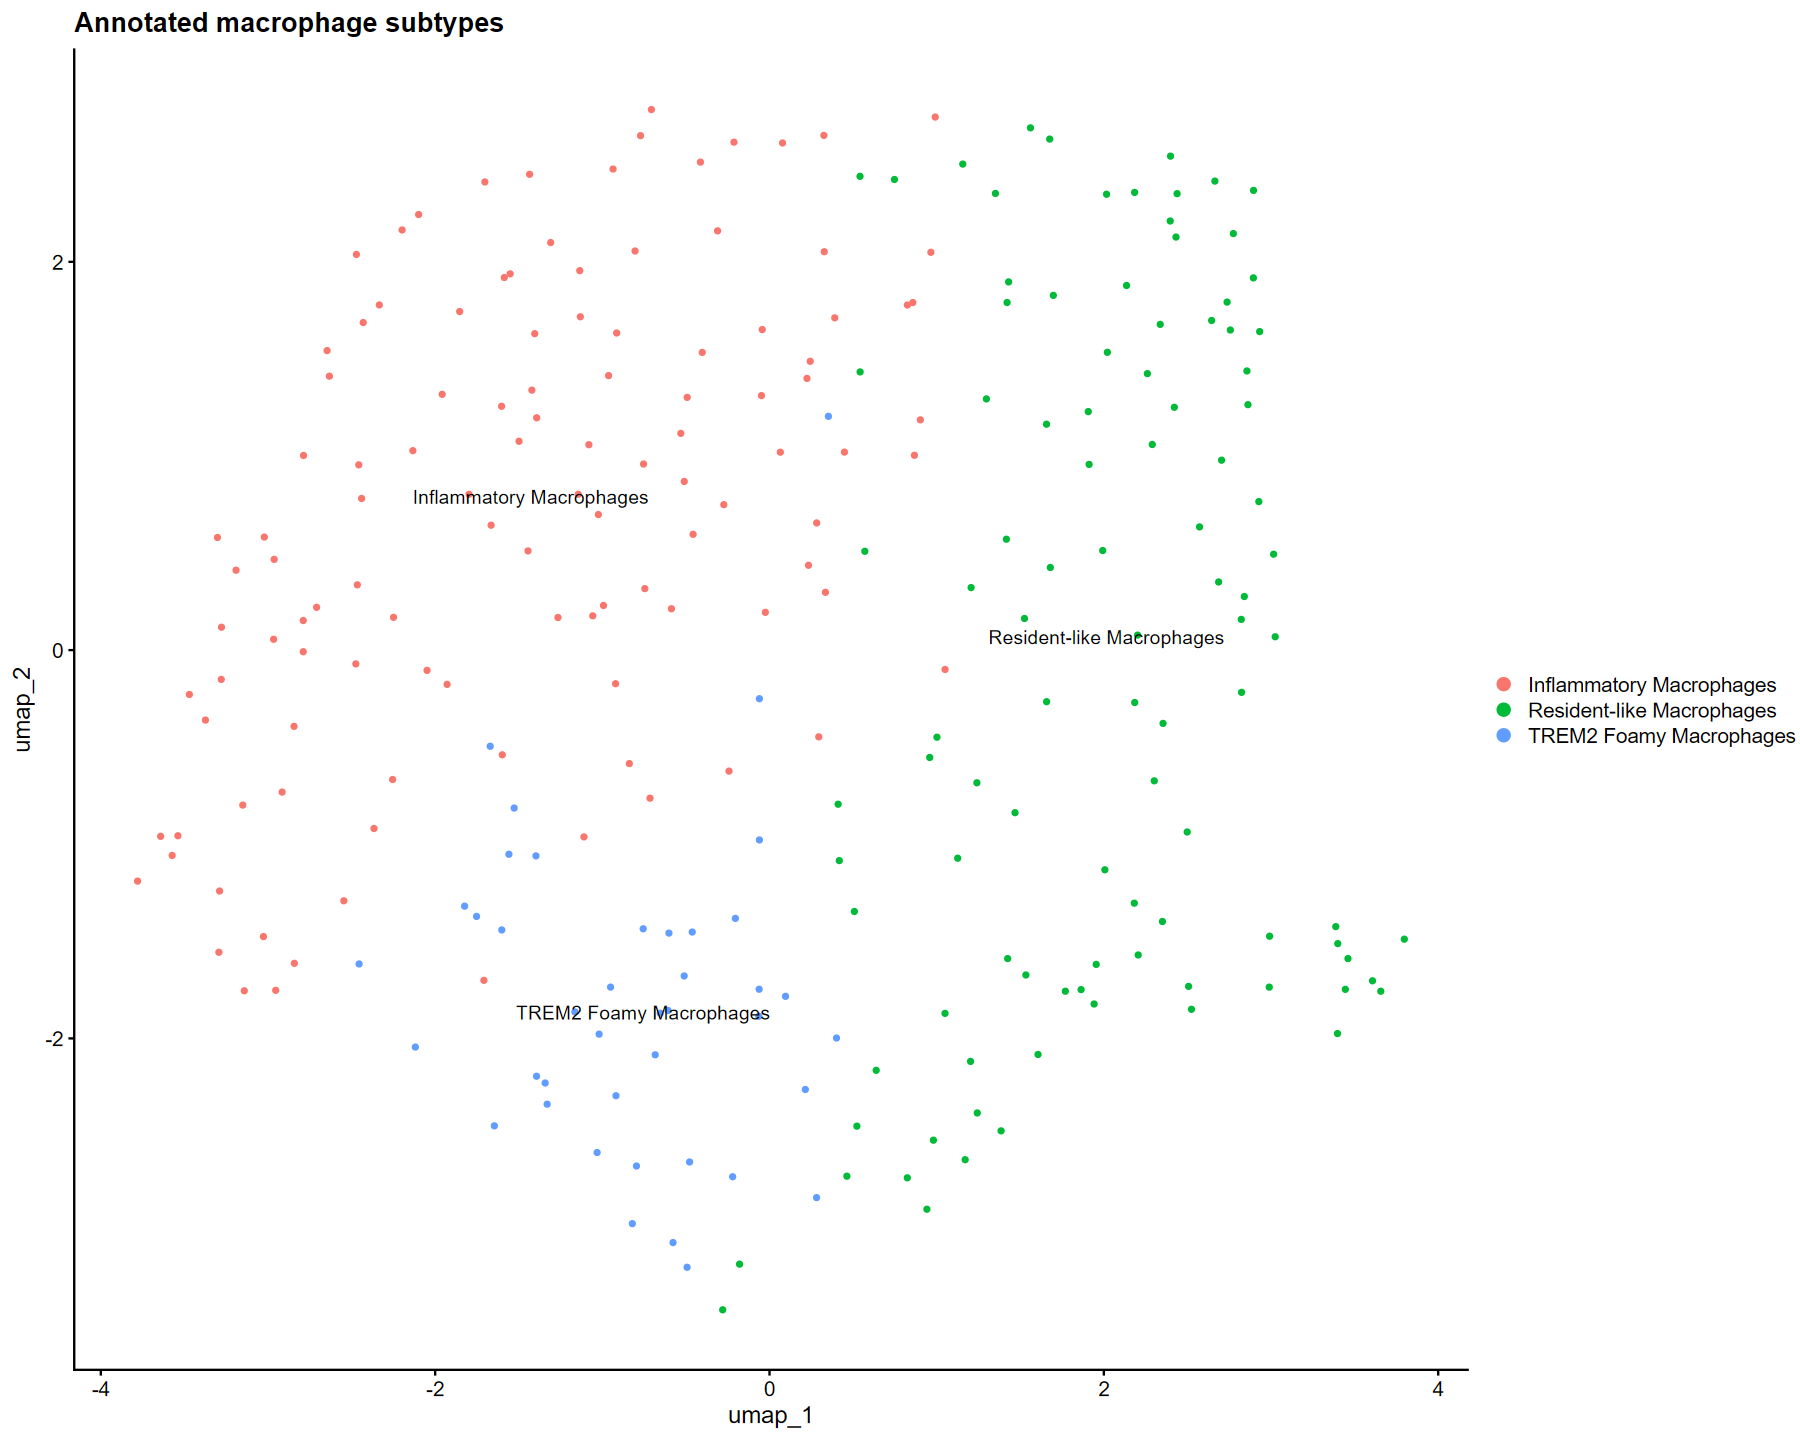

In [ ]:
# Plot table
combined_df

# Plotting annotations and titles
grid.arrange(
    subtype_annotated_plot + ggtitle("Annotated macrophage subtypes")
    subtype_origin_plot + ggtitle("DimPlot by origin"),
    ncol=1
)